In [1]:
import os
import argparse
import random

import torch
import cv2 as cv
import detectron2
import numpy as np
import matplotlib.pyplot as plt

from detectron2.config import get_cfg
import detectron2.model_zoo as model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

In [2]:
parser = argparse.ArgumentParser(description="Pothole Segmentation")
parser.add_argument("--path", type=str, default=os.path.join(os.getcwd(), "data"), help="Path to the data directory")
parser.add_argument("--target", type=str, default="images", help="Target directory (images, videos)", choices=["images", "videos"])
args, unknown = parser.parse_known_args()


path = args.path
if not os.path.exists(path):
    raise ValueError(f"Path {path} does not exist")

trainPath = os.path.join(path, args.target, "train")
valPath = os.path.join(path, args.target, "val")

if not os.path.exists(trainPath):
    raise ValueError(f"Path {trainPath} does not exist")
if not os.path.exists(valPath):
    raise ValueError(f"Path {valPath} does not exist")

trainCocoPath = os.path.join(trainPath, "cocoLabels.json")
valCocoPath = os.path.join(valPath, "cocoLabels.json")

---

## Registra Dataset in COCO Format

In [3]:
register_coco_instances("pothole_train", {}, trainCocoPath, os.path.join(trainPath, "images"))
register_coco_instances("pothole_val", {}, valCocoPath, os.path.join(valPath, "images"))

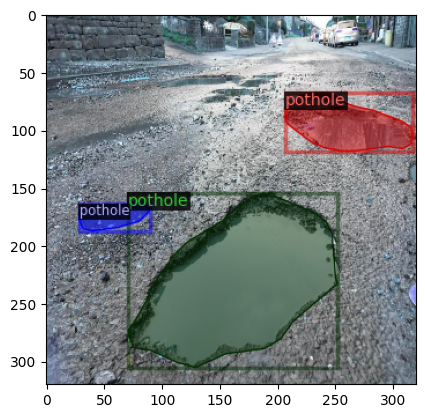

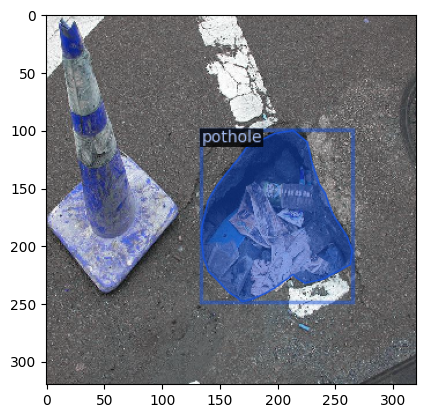

In [4]:
train = DatasetCatalog.get("pothole_train")
val = DatasetCatalog.get("pothole_val")

for elem in random.sample(train, 1):
    img = cv.imread(elem["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("pothole_train"), scale=0.5)
    vis = visualizer.draw_dataset_dict(elem)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()
for elem in random.sample(val, 1):
    img = cv.imread(elem["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("pothole_train"), scale=0.5)
    vis = visualizer.draw_dataset_dict(elem)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()